In [37]:
import os

import matplotlib.pyplot as plot
import numpy as np
import tensorflow as tf

from python.dataset.data_reader import read_dataset
from python.dlf.dlf import DLF
from python.dlf.losses import cross_entropy
from python.util import BATCH_SIZE, ModelMode

In [47]:
def draw_table(names, results, metric_names):
    data = []

    for metric in metric_names:
        x = []
        for result in results:
            x.append(result[metric])
        data.append(x)

    table = plot.table(
      cellText=data,
      rowLabels=metric_names,
      colLabels=names,
      loc='center'
    )

    table.set_fontsize(16)
    table.scale(2.5, 2.5)

    plot.axis('off')
    plot.grid(False)

    plot.show()

In [39]:
def read_checkpoint(model_name):
    checkpoint_path = '../output/checkpoint/aws/' + model_name + '/cp-{epoch:02d}.ckpt'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    return tf.train.latest_checkpoint(checkpoint_dir)

def build_model(model_mode, model_name):
    model = DLF(model_mode)
    model.build(input_shape=([BATCH_SIZE, 16], [BATCH_SIZE, 2]))

    latest = read_checkpoint(model_name)
    model.load_weights(latest)
    return model

In [40]:
_STEPS = 110

def cross_entropy_values(model, dataset, test_all_data=False):
    epoch_steps = dataset.epoch_steps()
    steps = epoch_steps if test_all_data else min(epoch_steps, _STEPS)

    win_ce = []
    loss_ce = []
    for i in range(steps):
        if i > 0 and i % 50 == 0:
            print("Iter number %d/%d" % (i, steps))

        features, bids, targets, win = dataset.next()
        survival_rate, rate_last = model.predict_on_batch([features, bids])
        cross_entropy_value = cross_entropy(targets, survival_rate)

        current_ce = win_ce if win else loss_ce
        current_ce.append(cross_entropy_value)

    print("Iter number %d/%d" % (steps, steps))

    win_ce_mean = np.array(win_ce).mean()
    loss_ce_mean = np.array(loss_ce).mean()

    return {'cross_entropy_win': win_ce_mean, 'cross_entropy_loss': loss_ce_mean}

In [41]:
dataset = read_dataset('../data', '2997', is_train=False)

data size  26944 

data size  129119 



In [42]:
dlf = build_model(ModelMode.DLF, 'dlf_2997_all__0.25_0.75_0.0001_20200502_1437')
dlf_attention = build_model(ModelMode.DLF_ATTENTION, 'dlf_attention_2997_all__0.25_0.75_0.0001_20200502_1753')

In [43]:
dlf_result = cross_entropy_values(dlf, dataset)
dlf_attention_result = cross_entropy_values(dlf_attention, dataset)

Iter number 50/110
Iter number 100/110
Iter number 110/110
Iter number 50/110
Iter number 100/110
Iter number 110/110


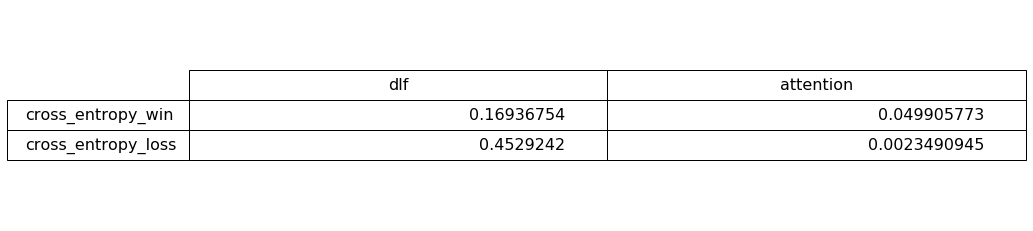

In [48]:
draw_table(['dlf', 'attention'], [dlf_result, dlf_attention_result], ['cross_entropy_win', 'cross_entropy_loss'])